In [101]:
import mesa
from mesa import Model, Agent
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
class DataProvider(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.data_quantity = self.model.num_data
        self.wealth = 0

In [103]:
class Participants(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.has_token = False
        self.purchase_price = None

        self.wealth = int(self.random.normalvariate(100, 20))
        self.wealth = max(0, self.wealth)
        self.utility = int(self.random.normalvariate(80, 15))
        self.utility = max(0, self.utility)
        
        self.is_listing = False
        self.listing_price = None
        self.has_ever_held_token = False

    def decide_sell_price(self):
        if not self.model.sell_orders:
            return self.purchase_price * 1.1
        
        #最も安い売り注文の価格を取得
        lowest_price = self.model.sell_orders[0]['price']

        #最安値より1％安い価格で出品
        price_to_list = int(lowest_price * 0.99)
        return price_to_list


    def decide_and_list_if_applicable(self):
        if self.has_token and not self.is_listing:
            if self.random.random() < self.model.listing_probability:
                price_to_list = self.decide_sell_price()
                if price_to_list is not None:
                    self.model.place_sell_order(price_to_list, self)
                    self.is_listing = True
                    self.listing_price = price_to_list

    def buy_if_interested(self):
        if self.has_ever_held_token:
            return

        if not self.model.sell_orders:
            return

        cheapest_order = self.model.sell_orders[0]
        price = cheapest_order['price']
        seller = cheapest_order['agent']

        if self.utility >= price and self.wealth >= price:
            self.model.execute_trade(self, seller, price)

    def discount_price(self):
        current_step = self.model.steps
        if self.is_listing:
            # 市場の全売り注文をチェック
            for order in self.model.sell_orders:
                if order['agent'] == self:
                    if order['step_created'] < current_step - 5:
                        # 価格を10%割引
                        discounted_price = int(order['price'] * 0.9)
                        order['price'] = discounted_price
                        order['step_created'] = current_step  # 更新されたステップを記録
                        self.listing_price = discounted_price
                        print(f"Participant {self.unique_id} discounted price to {discounted_price}.")

class DataMarket(Model):
    def __init__(self, num_participants, num_data, initial_price, listing_probability, markup_rate=0.2, seed=None):
        super().__init__(seed=seed)
        self.num_participants = num_participants
        self.num_data = num_data
        self.initial_price = initial_price
        self.listing_probability = listing_probability
        self.markup_rate = markup_rate
        self.steps = 0
        self.sell_orders = []
        self.trade_history = []

        # エージェントの生成
        self.provider = DataProvider.create_agents(self, n=1)[0] # AgentSetからインスタンスを直接取得
        self.participants = Participants.create_agents(self, n=self.num_participants)

        # DataProviderによる初期注文
        for _ in range(self.provider.data_quantity):
            self.place_sell_order(self.initial_price, self.provider)

        # DataCollectorの設定
        self.datacollector = DataCollector(
            model_reporters={
                "sell_orders_count": lambda m: len(m.sell_orders),
                "average_price": lambda m: np.mean([order['price'] for order in m.sell_orders]) if m.sell_orders else 0
            },
            agent_reporters={
                "wealth": "wealth",
                "has_token": "has_token",
                "is_listing": "is_listing"
            }
        )
        self.datacollector.collect(self) # 初期状態を収集

    def place_sell_order(self, price, agent):
        self.sell_orders.append({'price': price, 'agent': agent, 'step_created': self.steps})
        self.sell_orders.sort(key=lambda x: x['price'])

    def execute_trade(self, buyer, seller, price):
        # 取引履歴を記録
        trade_log = {
            'step': self.steps,
            'buyer_id': buyer.unique_id,
            'seller_id': seller.unique_id,
            'price': price,
            'seller_type': 'DataProvider' if isinstance(seller, DataProvider) else 'Participant'
        }
        self.trade_history.append(trade_log)

        # 買い手の状態変化
        buyer.wealth -= price
        buyer.has_token = True
        buyer.purchase_price = price
        buyer.has_ever_held_token = True

        # 売り手の状態変化
        if isinstance(seller, DataProvider):
            seller.wealth += price
            seller.data_quantity -= 1
            #print(f"wealth of DataProvider {seller.unique_id} updated to {seller.wealth}.")
        else: # 売り手がParticipantの場合
            seller.wealth += price
            seller.has_token = False
            seller.is_listing = False
            seller.listing_price = None

        # 成立した注文を市場から削除
        self.sell_orders.pop(0)

    def step(self):
        #print(f"--- Step {self.steps} ---")
        
        # フェーズ1: 売り手がランダムな順序で出品を試みる
        self.participants.shuffle_do("decide_and_list_if_applicable")
        
        # フェーズ1: 売り手が価格を割引する
        self.participants.shuffle_do("discount_price")
        
        # フェーズ2: 買い手がランダムな順序で購入を試みる
        self.participants.shuffle_do("buy_if_interested")
        
        # データ収集
        self.datacollector.collect(self)
        #print(f"Remaining sell orders: {len(self.sell_orders)}")

In [104]:
model = DataMarket(num_participants=100, num_data=30, initial_price=100, listing_probability=0.5, seed=42)

# 10ステップ実行
for i in range(100):
    model.step()

# 結果の取得
agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()
trade_history_df = pd.DataFrame(model.trade_history)

Participant 7 discounted price to 89.
Participant 16 discounted price to 88.
Participant 66 discounted price to 85.
Participant 81 discounted price to 87.
Participant 98 discounted price to 86.
Participant 73 discounted price to 86.
Participant 32 discounted price to 89.
Participant 62 discounted price to 87.
Participant 38 discounted price to 88.
Participant 15 discounted price to 85.
Participant 24 discounted price to 84.
Participant 96 discounted price to 86.
Participant 59 discounted price to 88.
Participant 101 discounted price to 89.
Participant 46 discounted price to 87.
Participant 33 discounted price to 85.
Participant 6 discounted price to 84.
Participant 59 discounted price to 79.
Participant 101 discounted price to 80.
Participant 46 discounted price to 78.
Participant 45 discounted price to 77.
Participant 67 discounted price to 76.
Participant 57 discounted price to 75.
Participant 54 discounted price to 74.
Participant 17 discounted price to 73.
Participant 14 discounted

--- Analysis Summary ---
      Average Trade Price  Sell Orders Count  DataProvider Wealth  Experienced Participants
Step                                                                                       
0                     0.0                 30                    0                         0
1                   100.0                 24                  600                         6
2                    97.0                 25                  600                         9
3                     0.0                 26                  600                         9
4                     0.0                 26                  600                         9
5                     0.0                 29                  600                         9
6                     0.0                 29                  600                         9
7                     0.0                 29                  600                         9
8                     0.0                 29           

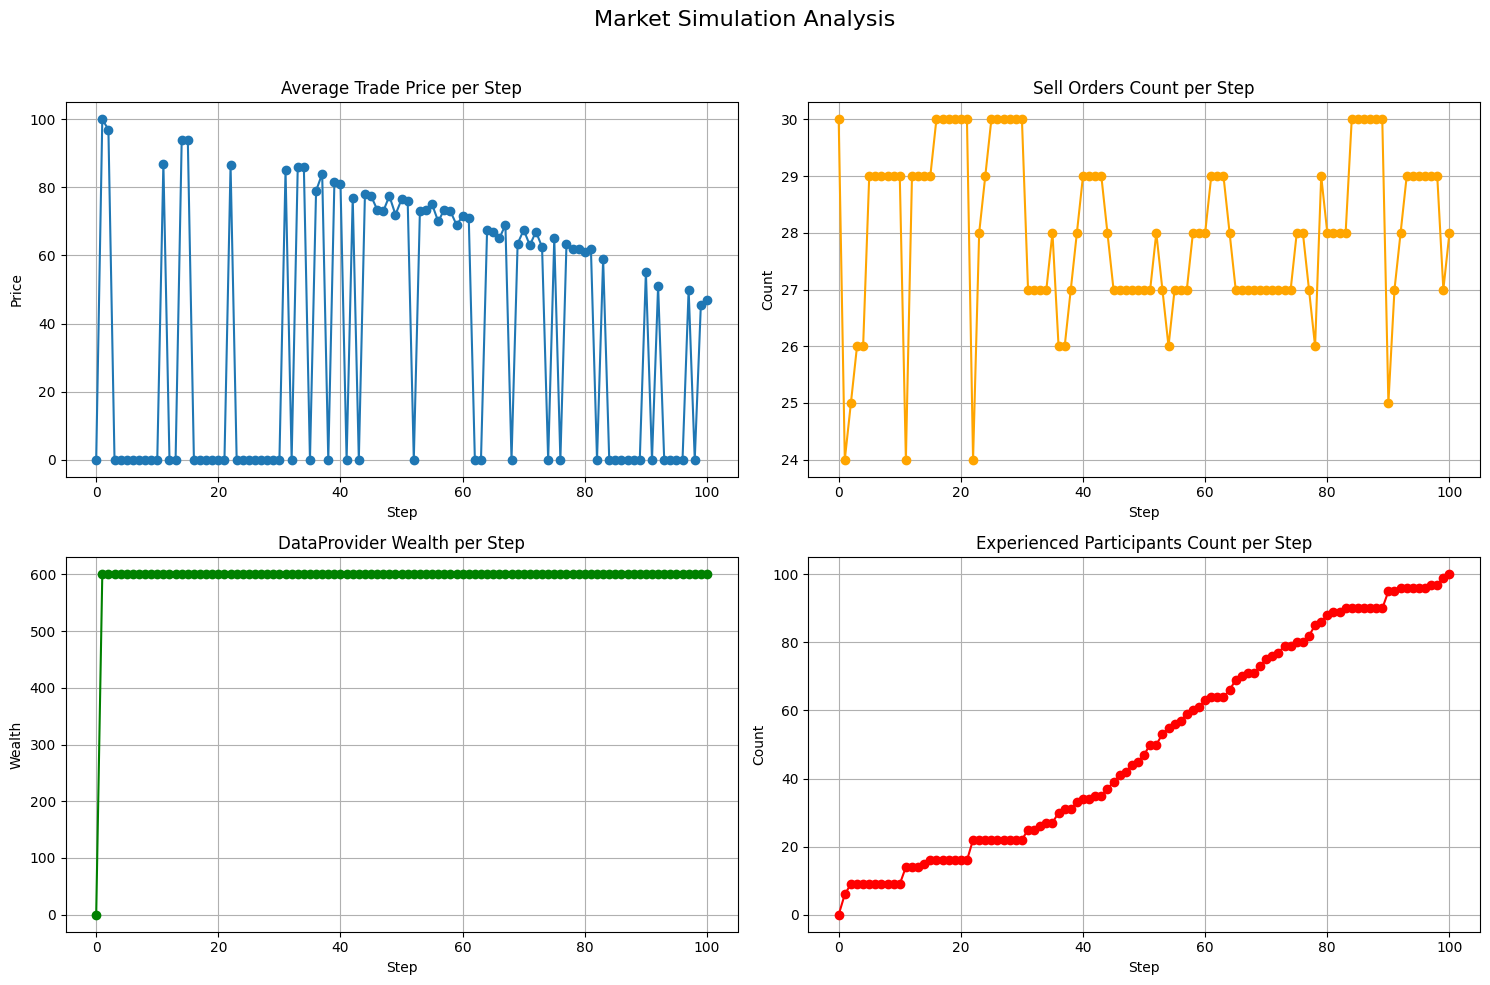

In [105]:
# --- 指標の計算と可視化 ---

# 1. 売値平均値の推移
avg_trade_price = trade_history_df.groupby('step')['price'].mean()

# 2. Sell Order数の推移
sell_orders_count = model_data['sell_orders_count']

# 3. DataProviderのWealthの推移
# DataProviderのunique_idは0と仮定
if 1 in agent_data.index.get_level_values('AgentID'):
    provider_wealth = agent_data.xs(1, level='AgentID')['wealth']
else:
    print('Warning: DataProvider (AgentID 0) not found in DataCollector. Calculating wealth from trade history.')
    provider_trades = trade_history_df[trade_history_df['seller_id'] == 1]
    if not provider_trades.empty:
        provider_wealth = provider_trades.groupby('step')['price'].sum().cumsum()
    else:
        provider_wealth = pd.Series(0, index=model_data.index) # 取引がなければ0
    provider_wealth = provider_wealth.reindex(model_data.index, method='ffill').fillna(0)

# 4. データ保有経験者数の推移
experienced_participants = []
for step in model_data.index:
    buyers = trade_history_df[trade_history_df['step'] <= step]['buyer_id'].unique()
    experienced_participants.append(len(buyers))
experienced_participants = pd.Series(experienced_participants, index=model_data.index)

# 結果をまとめたDataFrameを作成
summary_df = pd.DataFrame({
    'Average Trade Price': avg_trade_price,
    'Sell Orders Count': sell_orders_count,
    'DataProvider Wealth': provider_wealth,
    'Experienced Participants': experienced_participants
}).fillna(0) # 取引がなかったステップのNaNを0で埋める
summary_df.index.name = 'Step'

print("--- Analysis Summary ---")
print(summary_df.to_string())

# グラフの描画
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Market Simulation Analysis', fontsize=16)

summary_df['Average Trade Price'].plot(ax=axes[0, 0], title='Average Trade Price per Step', grid=True, marker='o')
axes[0, 0].set_ylabel('Price')
axes[0, 0].set_xlabel('Step')

summary_df['Sell Orders Count'].plot(ax=axes[0, 1], title='Sell Orders Count per Step', grid=True, marker='o', color='orange')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xlabel('Step')

summary_df['DataProvider Wealth'].plot(ax=axes[1, 0], title='DataProvider Wealth per Step', grid=True, marker='o', color='green')
axes[1, 0].set_ylabel('Wealth')
axes[1, 0].set_xlabel('Step')

summary_df['Experienced Participants'].plot(ax=axes[1, 1], title='Experienced Participants Count per Step', grid=True, marker='o', color='red')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xlabel('Step')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()